# Toy Regression

<div class="btn btn-notebook" role="button">
    <img src="../_static/images/colab_logo_32px.png"> [Run in Google Colab](https://colab.research.google.com/drive/1adhqoV6b0uEavLDmMfkiwtRjam0DrXux?usp=sharing)
</div>
<div class="btn btn-notebook" role="button">
    <img src="../_static/images/github_logo_32px.png"> [View on GitHub](https://github.com/adapt-python/adapt/blob/master/docs/examples/Regression.ipynb)
</div>

You will find here the application of DA methods from the ADAPT package on a simple one 
dimensional DA regression problem.

First we import packages needed in the following. We will use ``matplotlib Animation`` tools in order to
get a visual understanding of the mselected methods:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

## Experimental Setup

We now set the synthetic regression DA problem using the [make_regression_da](https://adapt-python.github.io/adapt/generated/adapt.utils.make_regression_da.html)
function from ``adapt.utils``.

In [ ]:
from adapt.utils import make_regression_da

Xs, ys, Xt, yt = make_regression_da()
tgt_index_lab_ = np.random.choice(100,3)
Xt_lab = Xt[tgt_index_lab_]; yt_lab = yt[tgt_index_lab_]

We define here a ``show`` function which we will use in the following to visualize the algorithms performances
on the toy problem.

In [ ]:
def show(ax, y_pred=None, X_src=Xs, weights_src=50, weights_tgt=100):
    ax.scatter(X_src, ys, s=weights_src, label="source", edgecolor="black")
    ax.scatter(Xt, yt, s=50, alpha=0.5, label="target", edgecolor="black")
    ax.scatter(Xt_lab, yt_lab, s=weights_tgt, 
                c="black", marker="s", alpha=0.7, label="target labeled")
    if y_pred is not None:
        ax.plot(np.linspace(-0.7, 0.6, 100), y_pred, c="red", lw=3, label="predictions")
        index_ = np.abs(Xt - np.linspace(-0.7, 0.6, 100)).argmin(1)
        score = np.mean(np.abs(yt - y_pred[index_]))
        score = " -- Tgt MAE = %.2f"%score
    else:
        score = ""
    ax.set_xlim((-0.7,0.6))
    ax.set_ylim((-1.3, 2.2))
    ax.legend(fontsize=16)
    ax.set_xlabel("X", fontsize=16)
    ax.set_ylabel("y = f(X)", fontsize=16)
    ax.set_title("Toy regression DA issue"+score, fontsize=18)
    return ax

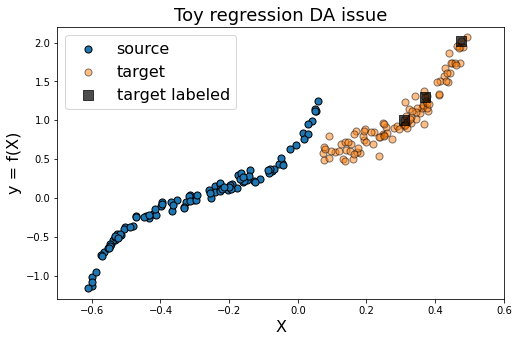

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
show(ax=ax)
plt.show()

Notice that we also define a ``writer`` which will be used to record the evolution of predictions through epochs.

As we can see in the figure above (plotting the output data ``y`` with respect to the inputs ``X``),
source and target data define two distinct domains. We have modeled here a classical supervised 
DA issue where the goal is to build a good model on orange data knowing only the labels (``y``) of the blue
and black points.

We now define the base model used to learn the task. We use here a neural network with two hidden layer.
We also define a ``SavePrediction`` callback in order to save the prediction of the neural network at
each epoch.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam

def get_model():
    model = Sequential()
    model.add(Dense(100, activation='elu', input_shape=(1,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.01), loss='mean_squared_error')
    return model

In [ ]:
from tensorflow.keras.callbacks import Callback

class SavePrediction(Callback):  
    """
    Callbacks which stores predicted
    labels in history at each epoch.
    """
    def __init__(self):
        self.X = np.linspace(-0.7, 0.6, 100).reshape(-1, 1)
        self.custom_history_ = []
        super().__init__()
            
    def on_epoch_end(self, batch, logs={}):
        """Applied at the end of each epoch"""
        predictions = self.model.predict_on_batch(self.X).ravel()
        self.custom_history_.append(predictions)

## TGT Only

First, let's fit a network only on the three labeled target data. As we could have guessed,
this is not sufficient to build an efficient model on the whole target domain.

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model = get_model()
save_preds = SavePrediction()
model.fit(Xt_lab, yt_lab, callbacks=[save_preds], epochs=100, batch_size=64, verbose=0);

In [ ]:
def animate(i, *fargs):
    ax.clear()
    y_pred = save_preds.custom_history_[i].ravel()
    if len(fargs)<1:
        show(ax, y_pred)
    else:
        show(ax, y_pred, **fargs[0])

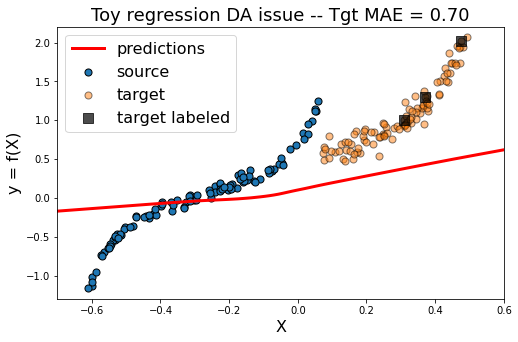

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ani = animation.FuncAnimation(fig, animate, frames=100, blit=False, repeat=True)

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ani = animation.FuncAnimation(fig, animate, frames=100, repeat=False)
ani.save('tgtOnly.mp4', writer=writer)

## Src Only

We would like to use the large amount of labeled source data to improve
the training of the neural network on the target domain. However,
as we can see on the figure below, using only the source
dataset fails to provide an efficient model.

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model = get_model()
save_preds = SavePrediction()
model.fit(Xs, ys, callbacks=[save_preds], epochs=100, batch_size=100, verbose=0);

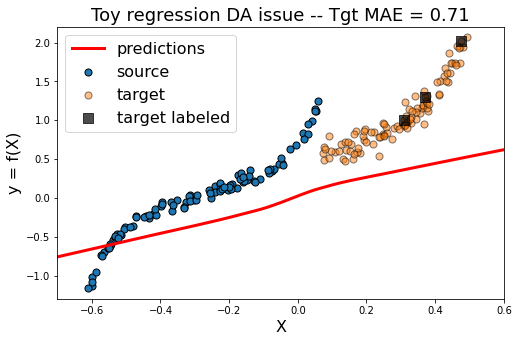

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ani = animation.FuncAnimation(fig, animate, frames=100, blit=False, repeat=True)

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

## All

Same thing happen when using both source and target labeled data. As the source sample ovewhelms the target one,
the model is not fitted enough on the target domain.

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

model = get_model()
save_preds = SavePrediction()
model.fit(np.concatenate((Xs, Xt_lab)),
          np.concatenate((ys, yt_lab)),
          callbacks=[save_preds],
          epochs=100, batch_size=110, verbose=0);

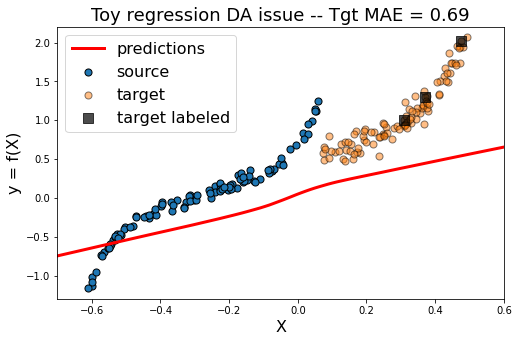

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ani = animation.FuncAnimation(fig, animate, frames=100, blit=False, repeat=True)

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

## CORAL

Let's now consider the domain adaptation method [CORAL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.CORAL.html) 
This "two-stage" method first perfroms a feature alignment on source data and then fit
an estimator on the new feature space.

In [ ]:
from adapt.feature_based import CORAL

save_preds = SavePrediction()
model = CORAL(get_model(), lambda_=1000., random_state=0)
model.fit(Xs.reshape(-1, 1), ys, Xt,
          callbacks=[save_preds], epochs=100, batch_size=110, verbose=0);

Covariance Matrix alignement...
Previous covariance difference: 0.024858
New covariance difference: 0.000624
Fit estimator...


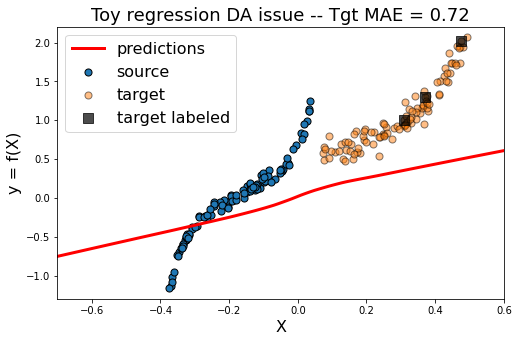

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
X_transformed = model.predict_features(Xs.reshape(-1, 1), domain="src").ravel()
ani = animation.FuncAnimation(fig, animate, frames=100, blit=False, repeat=True,
                              fargs=(dict(X_src=X_transformed),))

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

As we can see. when using CORAL method, source input data are translated closer to
target data. However, for this example, this is not enough to obtain a good model
on the target domain.

## TrAdaBoostR2

We now consider an instance-based method: [TrAdaBoostR2](https://adapt-python.github.io/adapt/generated/adapt.instance_based.TrAdaBoostR2.html).
This method consists in a reverse boosting algorithm decreasing the weights of source data poorly predicted
at each boosting iteraton.

In [ ]:
from adapt.instance_based import TrAdaBoostR2

model = TrAdaBoostR2(get_model(), n_estimators=30, random_state=0)

save_preds = SavePrediction()
model.fit(Xs.reshape(-1, 1), ys, Xt_lab, yt_lab,
          callbacks=[save_preds], epochs=100, batch_size=110, verbose=0);

Iteration 0 - Error: 0.5000
Iteration 1 - Error: 0.5000
Iteration 2 - Error: 0.5000
Iteration 3 - Error: 0.5000
Iteration 4 - Error: 0.5000
Iteration 5 - Error: 0.5000
Iteration 6 - Error: 0.5000
Iteration 7 - Error: 0.5000
Iteration 8 - Error: 0.5000
Iteration 9 - Error: 0.5000
Iteration 10 - Error: 0.5000
Iteration 11 - Error: 0.5000
Iteration 12 - Error: 0.5000
Iteration 13 - Error: 0.5000
Iteration 14 - Error: 0.5000
Iteration 15 - Error: 0.5000
Iteration 16 - Error: 0.4436
Iteration 17 - Error: 0.4358
Iteration 18 - Error: 0.3870
Iteration 19 - Error: 0.3309
Iteration 20 - Error: 0.2878
Iteration 21 - Error: 0.2025
Iteration 22 - Error: 0.1251
Iteration 23 - Error: 0.0577
Iteration 24 - Error: 0.0391
Iteration 25 - Error: 0.0311
Iteration 26 - Error: 0.0234
Iteration 27 - Error: 0.0199
Iteration 28 - Error: 0.0187
Iteration 29 - Error: 0.0183


In [ ]:
def animate_tradaboost(i):
    ax.clear()
    i *= 10
    j = int(i / 100)
    y_pred = save_preds.custom_history_[i].ravel()
    weights_src = 10000 * model.sample_weights_src_[j]
    weights_tgt = 10000 * model.sample_weights_tgt_[j]
    show(ax, y_pred, weights_src=weights_src, weights_tgt=weights_tgt)

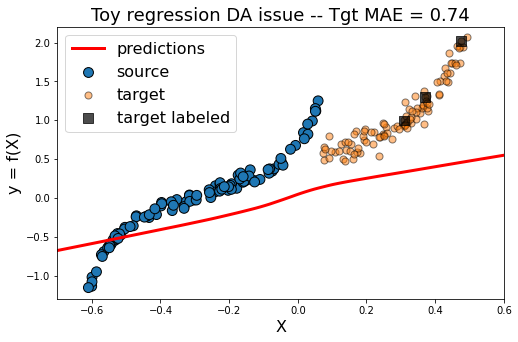

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ani = animation.FuncAnimation(fig, animate_tradaboost, frames=299, blit=False, repeat=True)

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

As we can see on the figure above, [TrAdaBoostR2](https://adapt-python.github.io/adapt/generated/adapt.instance_based.TrAdaBoostR2.html) perfroms very well
on this toy DA issue! The importance weights are described by the size of data points.
We observe that the weights of source instances close to 0 are decreased as the weights of target instances increase.
This source instances indeed misleaded the fitting of the network on the target domain. Decreasing their weights helps
then a lot to obtain a good target model.

## RegularTransferNN

Finally, we consider here the paremeter-based method [RegularTransferNN](https://adapt-python.github.io/adapt/generated/adapt.parameter_based.RegularTransferNN.html).
This method fits the target labeled data with a regularized loss. During training, the mean squared error on target data is
regularized with the euclidean distance between the target model parameters and the ones of a pre-trained source model.

In [ ]:
from adapt.parameter_based import RegularTransferNN

np.random.seed(0)
tf.random.set_seed(0)

save_preds = SavePrediction()
model_0 = get_model()
model_0.fit(Xs.reshape(-1, 1), ys, callbacks=[save_preds], epochs=100, batch_size=110, verbose=0);
model = RegularTransferNN(model_0, lambdas=1.0, random_state=0)
model.fit(Xt_lab, yt_lab, callbacks=[save_preds], epochs=100, batch_size=110, verbose=0);

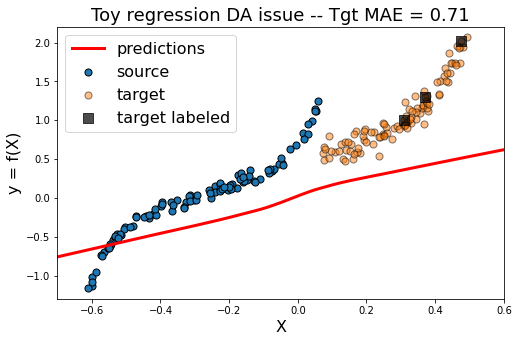

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ani = animation.FuncAnimation(fig, animate, frames=200, blit=False, repeat=True)

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.